<a href="https://colab.research.google.com/github/rnop/nmr_tournament/blob/main/introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction to the Numerai Tournament
Numerai is a hedge fund that trades the global markets based on models created by data scientists all over the world. Numerai is unique in that it provides free high-quality financial datasets that are worth millions of dollars to any user wanting to participate in their tournament. Users are able to build their own models on this anonymized and obfuscated dataset, submit their predictions, and follow their investment performance on the live stock market. If users are confident about their models, they are able to stake on them with real money using Numerai's cryptocurrency, Numeraire (NMR).

### About this Notebook
The purpose of this notebook is to provide an introduction on how to approach the main Numerai tournament. Alot of the code is taken from example scripts from Numerai's official GitHub here: https://github.com/numerai/example-scripts

What's included:
* how to read in the Numerai data via API
* approaches to dimensionality reduction
* training an xgboost model 
* bayesian optimization techniques
* calculating predictions from the current round

### Disclaimer
**This model is not guaranteed to make you money.** I am currently not staking this particular model in the tournament. This notebook only serves to provide you an introduction to the tournament and to give some of my personal input on how to tackle this data science problem. 

In [ ]:
# Download the numerai library 
! pip install numerapi

In [ ]:
import pandas as pd
import numpy as np
import numerapi

### Import data
* Training data contains 501,808 observations
* Tournament data contains the testing and validation sets, and the live observations you need to predict on for the upcoming round

In [ ]:
host = 'numerai-public-datasets.s3-us-west-2.amazonaws.com'
train_filename = 'latest_numerai_training_data.csv.xz'
tourney_filename = 'latest_numerai_tournament_data.csv.xz'

train_df = pd.read_csv('https://{}/{}'.format(host, train_filename))
tourney_df = pd.read_csv('https://{}/{}'.format(host, tourney_filename))

#Confirm round number
napi = numerapi.NumerAPI(verbosity="info")
current_round = napi.get_current_round()
print()
print("ROUND NUMBER: ", current_round)


ROUND NUMBER:  267


In [ ]:
train_df.head()

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,feature_intelligence11,feature_intelligence12,feature_charisma1,feature_charisma2,feature_charisma3,feature_charisma4,feature_charisma5,feature_charisma6,feature_charisma7,feature_charisma8,feature_charisma9,feature_charisma10,feature_charisma11,feature_charisma12,feature_charisma13,feature_charisma14,feature_charisma15,feature_charisma16,feature_charisma17,feature_charisma18,feature_charisma19,feature_charisma20,feature_charisma21,feature_charisma22,feature_charisma23,feature_charisma24,feature_charisma25,...,feature_wisdom8,feature_wisdom9,feature_wisdom10,feature_wisdom11,feature_wisdom12,feature_wisdom13,feature_wisdom14,feature_wisdom15,feature_wisdom16,feature_wisdom17,feature_wisdom18,feature_wisdom19,feature_wisdom20,feature_wisdom21,feature_wisdom22,feature_wisdom23,feature_wisdom24,feature_wisdom25,feature_wisdom26,feature_wisdom27,feature_wisdom28,feature_wisdom29,feature_wisdom30,feature_wisdom31,feature_wisdom32,feature_wisdom33,feature_wisdom34,feature_wisdom35,feature_wisdom36,feature_wisdom37,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n000315175b67977,era1,train,0.00,0.50,0.25,0.00,0.5,0.25,0.25,0.25,0.75,0.75,0.25,0.25,1.00,0.75,0.5,1.0,0.5,0.00,0.50,0.50,0.00,0.0,0.00,1.00,0.25,0.00,0.50,0.25,0.75,0.50,1.00,0.75,0.75,0.5,0.50,0.75,0.5,...,0.75,0.75,0.75,0.50,1.00,1.00,0.50,0.75,0.5,0.25,0.25,0.75,0.50,1.00,0.5,0.75,0.75,0.25,0.50,1.00,0.75,0.50,0.50,1.00,0.25,0.5,0.50,0.50,0.75,1.00,1.00,1.00,0.75,0.50,0.75,0.50,1.00,0.50,0.75,0.50
1,n0014af834a96cdd,era1,train,0.00,0.00,0.00,0.25,0.5,0.00,0.00,0.25,0.50,0.50,0.00,0.50,0.00,0.50,0.5,0.5,0.5,0.50,0.25,0.25,0.50,0.0,1.00,0.50,0.50,0.50,0.75,0.50,0.50,0.75,0.25,0.50,0.75,0.5,0.25,0.75,0.5,...,0.25,0.25,0.25,1.00,1.00,0.50,0.50,0.50,0.0,0.25,1.00,0.50,1.00,1.00,0.5,0.50,0.50,1.00,0.25,0.75,1.00,0.25,0.25,1.00,0.50,0.5,0.50,0.75,0.75,0.75,1.00,1.00,0.00,0.00,0.75,0.25,0.00,0.25,1.00,0.25
2,n001c93979ac41d4,era1,train,0.25,0.50,0.25,0.25,1.0,0.75,0.75,0.25,0.00,0.25,0.50,1.00,0.50,0.75,0.5,0.5,1.0,0.50,0.50,0.50,0.25,0.0,0.25,0.75,0.75,0.75,0.50,0.75,0.50,0.25,0.50,0.75,0.25,0.5,0.50,0.75,0.5,...,0.25,1.00,1.00,1.00,0.50,1.00,1.00,1.00,0.5,1.00,0.00,1.00,1.00,0.50,1.0,0.75,1.00,0.00,0.50,0.75,0.00,1.00,0.50,0.50,0.75,1.0,0.75,1.00,0.25,0.50,0.25,0.50,0.00,0.00,0.50,1.00,0.00,0.25,0.75,0.25
3,n0034e4143f22a13,era1,train,1.00,0.00,0.00,0.50,0.5,0.25,0.25,0.75,0.25,0.50,0.50,0.50,0.75,0.50,1.0,0.5,0.5,0.00,1.00,0.00,0.75,0.0,0.50,0.50,0.50,0.50,0.00,0.50,0.50,0.75,0.75,0.50,0.25,0.5,0.50,0.50,0.5,...,1.00,1.00,0.75,0.75,1.00,0.75,0.75,0.75,1.0,0.75,1.00,0.75,1.00,0.75,1.0,0.00,0.50,0.75,1.00,0.75,1.00,0.75,1.00,1.00,0.00,0.5,0.75,0.75,1.00,0.75,1.00,1.00,0.75,0.75,1.00,1.00,0.75,1.00,1.00,0.25
4,n00679d1a636062f,era1,train,0.25,0.25,0.25,0.25,0.0,0.25,0.50,0.25,0.25,0.50,0.25,0.25,0.75,0.50,0.0,0.5,0.5,0.25,0.00,0.50,0.00,0.5,0.25,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.75,0.50,0.25,0.5,0.50,0.50,0.5,...,1.00,0.25,0.75,1.00,0.75,0.00,0.00,0.75,0.5,1.00,0.50,0.75,0.25,0.50,0.0,0.50,0.50,0.50,0.75,0.75,0.50,0.75,0.25,0.75,0.50,0.5,0.25,0.25,0.75,0.50,0.75,0.75,0.25,0.50,0.75,0.00,0.50,0.25,0.75,0.75


In [ ]:
tourney_df.head()

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,feature_intelligence11,feature_intelligence12,feature_charisma1,feature_charisma2,feature_charisma3,feature_charisma4,feature_charisma5,feature_charisma6,feature_charisma7,feature_charisma8,feature_charisma9,feature_charisma10,feature_charisma11,feature_charisma12,feature_charisma13,feature_charisma14,feature_charisma15,feature_charisma16,feature_charisma17,feature_charisma18,feature_charisma19,feature_charisma20,feature_charisma21,feature_charisma22,feature_charisma23,feature_charisma24,feature_charisma25,...,feature_wisdom8,feature_wisdom9,feature_wisdom10,feature_wisdom11,feature_wisdom12,feature_wisdom13,feature_wisdom14,feature_wisdom15,feature_wisdom16,feature_wisdom17,feature_wisdom18,feature_wisdom19,feature_wisdom20,feature_wisdom21,feature_wisdom22,feature_wisdom23,feature_wisdom24,feature_wisdom25,feature_wisdom26,feature_wisdom27,feature_wisdom28,feature_wisdom29,feature_wisdom30,feature_wisdom31,feature_wisdom32,feature_wisdom33,feature_wisdom34,feature_wisdom35,feature_wisdom36,feature_wisdom37,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n0003aa52cab36c2,era121,validation,0.25,0.75,0.50,0.50,0.0,0.75,0.5,0.25,0.50,0.5,0.25,0.0,0.25,0.50,0.25,0.00,0.25,1.00,1.00,0.25,1.00,1.00,0.25,0.25,0.0,0.50,0.25,0.75,0.00,0.50,0.25,0.25,0.25,0.50,0.00,0.50,1.00,...,0.00,0.0,0.25,0.5,0.25,0.25,0.00,0.25,0.00,0.25,0.50,0.50,0.50,0.50,0.00,0.25,0.75,0.25,0.25,0.50,0.25,0.00,0.25,0.50,0.25,0.5,0.25,0.25,1.00,0.75,0.75,0.75,1.00,0.75,0.50,0.5,1.0,0.00,0.00,0.25
1,n000920ed083903f,era121,validation,0.75,0.50,0.75,1.00,0.5,0.00,0.0,0.75,0.25,0.0,0.75,0.5,0.00,0.25,0.50,0.00,1.00,0.25,0.25,1.00,1.00,0.25,0.75,0.00,0.0,0.75,1.00,1.00,0.00,0.25,0.00,0.00,0.25,0.25,0.25,0.00,1.00,...,0.50,0.5,0.25,1.0,0.50,0.25,0.00,0.25,0.50,0.25,1.00,0.25,0.00,0.50,0.75,0.75,0.50,1.00,1.00,0.25,0.50,0.25,0.50,0.50,0.50,0.5,0.25,0.25,0.75,0.50,0.50,0.50,0.75,1.00,0.75,0.5,0.5,0.50,0.50,0.50
2,n0038e640522c4a6,era121,validation,1.00,0.00,0.00,1.00,1.0,1.00,1.0,1.00,0.50,0.5,1.00,1.0,1.00,0.75,0.50,0.50,1.00,1.00,0.50,0.50,0.00,1.00,0.50,1.00,0.5,1.00,0.50,1.00,0.25,1.00,1.00,1.00,0.50,1.00,1.00,0.75,1.00,...,0.25,0.5,0.00,0.0,0.00,0.25,0.25,0.00,0.50,0.00,0.00,0.00,0.25,0.00,0.25,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.75,0.0,0.00,0.25,0.00,0.00,0.00,0.00,0.50,0.25,0.00,0.0,0.5,0.50,0.00,1.00
3,n004ac94a87dc54b,era121,validation,0.75,1.00,1.00,0.50,0.0,0.00,0.0,0.50,0.75,1.0,0.75,0.0,0.50,0.00,0.50,0.75,0.50,0.75,0.25,0.75,0.25,0.75,0.25,0.75,1.0,0.50,0.50,0.75,0.50,1.00,0.50,0.25,0.75,0.25,0.75,0.25,0.75,...,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.25,0.00,0.25,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.75,0.00,0.00,0.25,0.25,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.00,0.0,0.0,0.25,0.25,0.50
4,n0052fe97ea0c05f,era121,validation,0.25,0.50,0.50,0.25,1.0,0.50,0.5,0.25,0.25,0.5,0.50,1.0,1.00,1.00,1.00,0.75,0.50,0.50,0.50,0.75,0.00,0.00,0.00,0.25,0.0,0.00,0.75,0.25,1.00,0.25,1.00,0.75,0.00,1.00,0.75,0.75,0.75,...,0.00,0.5,0.50,0.0,0.75,0.50,0.75,0.25,0.25,0.25,0.00,0.25,0.50,0.25,1.00,1.00,1.00,0.00,0.25,0.00,0.00,0.25,0.25,0.75,1.00,1.0,0.75,0.75,0.50,0.50,0.50,0.75,0.00,0.00,0.75,1.0,0.0,0.25,1.00,0.75


In [ ]:
# Number of observations in each dataset type
tourney_df['data_type'].value_counts()

test          1593237
validation     137779
live             5389
Name: data_type, dtype: int64

### Data Preprocessing
Most of the data cleaning has been done by Numerai in order to anonymize and obfuscate the data to us. This is done purposefully because of the data sharing rights from the data vendors Numerai spends millions of dollars on (thank you Numerai!). 

Steps:
* Extract features
* Convert era from string to integers

In [ ]:
# Extract features
tourney_ids = tourney_df['id']
features = [c for c in tourney_df if c.startswith('feature')]

# The training data is also grouped into 120 different eras (1-120)
train_df["erano"] = train_df["era"].str.slice(3).astype(int)

valid_df = tourney_df[tourney_df['data_type']=='validation']
valid_df["erano"] = valid_df["era"].str.slice(3).astype(int)

# Extract eras
eras = train_df["erano"]
target = "target"

print("Training:", train_df.shape)
print("Validation:", valid_df.shape)
print("Tournament:", tourney_df.shape)

Training: (501808, 315)
Validation: (137779, 315)
Tournament: (1736405, 314)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
print("First five features:")
print(features[:5])
print()
print("Number of unique eras in training data: ", len(set(eras)))

First five features:
['feature_intelligence1', 'feature_intelligence2', 'feature_intelligence3', 'feature_intelligence4', 'feature_intelligence5']

Number of unique eras in training data:  120


### Split the training data into training/testing sets
Things to think about:
* Is it useful to use all of the features?
* How should we think about the different eras in the data?
* Do some features matter more in particular eras than in other eras?

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_df[features], train_df[target],
                                                    test_size=0.25, random_state=0)

print("X_train size: ", X_train.shape)
print("X_test_size: ", X_test.shape)

X_train size:  (376356, 310)
X_test_size:  (125452, 310)


### Dimensionality Reduction Techniques
The original dataset has 310 features so it might be useful to reduce the number of features. Here I will implement the following dimension reduction techniques:
* PCA
* K-Means Clustering

PCA
* You can change the number of components or % variance retained

In [ ]:
from sklearn.decomposition import PCA

# You can specify the number of components
pca = PCA(n_components=120)
pca_train = pca.fit_transform(X_train)
explained_variance = pca.explained_variance_ratio_
print(np.cumsum(explained_variance))

[0.10420083 0.18434788 0.23781185 0.27809144 0.31211651 0.34185984
 0.36638192 0.38865699 0.40826849 0.42644541 0.44202931 0.45648403
 0.46998241 0.48279143 0.49494177 0.50692192 0.51838483 0.5293772
 0.54021484 0.55043026 0.56035963 0.57011853 0.57947186 0.58864781
 0.59747686 0.60579155 0.61383015 0.62180926 0.6294822  0.6369286
 0.64428767 0.65146668 0.65836099 0.66518295 0.67180242 0.67836877
 0.68466644 0.69086353 0.69690065 0.70276687 0.70850262 0.71413115
 0.71965471 0.72507904 0.73038158 0.73555205 0.74058998 0.74546826
 0.75023816 0.75497613 0.75963509 0.76420082 0.76869342 0.77315534
 0.77747269 0.78173191 0.78592465 0.79006857 0.79408329 0.79808811
 0.80202667 0.80588437 0.8096537  0.81335562 0.81699491 0.82057577
 0.82404153 0.82747084 0.83087077 0.83419196 0.83745956 0.84072437
 0.84393026 0.84710119 0.85022973 0.85324693 0.85624378 0.85916327
 0.86201852 0.86478824 0.86752505 0.87021991 0.87284845 0.87545582
 0.87804558 0.88059169 0.88307603 0.88551711 0.88792849 0.890274

In [ ]:
# You could also specify the % of variance you want to retain
pca = PCA(n_components=0.90) #specify 90% retention 
pca_train = pca.fit_transform(X_train)

# Explained variance of each component
explained_variance = pca.explained_variance_ratio_
print("Number of components with % variance: ", len(explained_variance))
print(np.cumsum(explained_variance))

Number of components with % variance:  95
[0.10420083 0.18434788 0.23781185 0.27809144 0.31211651 0.34185984
 0.36638192 0.38865699 0.40826849 0.42644541 0.44202931 0.45648403
 0.46998241 0.48279143 0.49494177 0.50692192 0.51838483 0.5293772
 0.54021484 0.55043026 0.56035963 0.57011853 0.57947186 0.58864781
 0.59747686 0.60579155 0.61383015 0.62180926 0.6294822  0.6369286
 0.64428767 0.65146668 0.65836099 0.66518296 0.67180242 0.67836877
 0.68466644 0.69086353 0.69690065 0.70276688 0.70850262 0.71413116
 0.71965472 0.72507905 0.73038159 0.73555206 0.74059    0.74546827
 0.75023817 0.75497615 0.75963511 0.76420085 0.76869344 0.77315537
 0.77747272 0.78173194 0.7859247  0.79006862 0.79408334 0.79808818
 0.80202674 0.80588445 0.80965381 0.81335573 0.81699503 0.82057589
 0.8240417  0.82747103 0.83087104 0.83419225 0.83745992 0.84072477
 0.84393068 0.84710162 0.85023017 0.85324781 0.8562447  0.85916427
 0.86201979 0.86478959 0.86752645 0.87022146 0.87285012 0.87545754
 0.87804736 0.88059364

In [ ]:
print("Original X_train shape:", X_train.shape)
print("PCA Transformed X_train shape:", pca_train.shape)

Original X_train shape: (376356, 310)
PCA Transformed X_train shape: (376356, 95)


K-Means Clustering
* You can change the number of clusters

In [ ]:
from sklearn.cluster import KMeans, MiniBatchKMeans

# Reduce to 120 clusters
kmeans120 = MiniBatchKMeans(n_clusters=120, random_state=6).fit(X_train)
kmeans120_train = kmeans120.transform(X_train)

In [ ]:
print("Original X_train shape:", X_train.shape)
print("K-Means Clustered X_train shape:", kmeans120_train.shape)

Original X_train shape: (376356, 310)
K-Means Clustered X_train shape: (376356, 120)


### Bayesian Optimization for xgboost
Documentation: https://github.com/fmfn/BayesianOptimization
* I am going to use the PCA transformed training data but you can easily switch it to PCA or K-means clustering
* set 'tree_method':'gpu_hist' to train on GPU for faster training

In [ ]:
# Download bayesian-optimization library
! pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp37-none-any.whl size=11686 sha256=1ef86227adf191a6a01d7a3e3cf1077afcf3cf5137d2fc728114bb6269081eeb
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [ ]:
import xgboost
from bayes_opt import BayesianOptimization

# Convert autoencoded training data to DMatrix for XGBoost
dtrain = xgboost.DMatrix(pca_train, y_train)
 
def bo_tune_xgb(max_depth, gamma, learning_rate, subsample, colsample_bytree, min_child_weight, n_estimators, alpha, eta):
    params = {'max_depth': int(max_depth),
              'gamma': gamma,
              'learning_rate': learning_rate,
              'subsample': subsample,
              'colsample_bytree': colsample_bytree,
              'min_child_weight': min_child_weight,
              'n_estimators': int(n_estimators),
              'alpha': alpha,
              'eta': eta,
              'eval_metric': 'rmse',
              'tree_method': 'gpu_hist'}
 
    #Cross validating with the specified parameters in 3 folds
    cv_result = xgboost.cv(params, dtrain, nfold=3)
    #Return the negative RMSE
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

#### n_iter 
* controls how many bayesian optimization steps to perform, more steps = more likely to find a good maximization

#### init_points 
* controls how many steps of random exploration you want to perform to help diversify the exploration space

#### acquisition functions
* decides how to guide the optimization
* acq: {'ucb', 'ei', 'poi'}

In [ ]:
# Initial Bayesian Optimization Search
xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (4,12),
                                             'gamma': (0.1, 1),
                                             'subsample' : (0.5, 1),
                                             'learning_rate' : (0.0001, 0.01),
                                             'colsample_bytree': (0.7, 1),
                                             'min_child_weight': (4, 10),
                                             'n_estimators':(80, 240),
                                             'alpha': (0.1, 1),
                                             'eta': (0.1, 0.3)
                                            })

xgb_bo.maximize(n_iter=5, init_points=5, acq='ei')

|   iter    |  target   |   alpha   | colsam... |    eta    |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        | -0.2235   |  0.7098   |  0.7666   |  0.2587   |  0.2934   |  0.008873 |  4.542    |  4.241    |  150.4    |  0.6259   |
|  2        | -0.2235   |  0.1985   |  0.8442   |  0.2617   |  0.2992   |  0.005382 |  7.494    |  6.304    |  80.55    |  0.7618   |
|  3        | -0.2235   |  0.8231   |  0.8734   |  0.2961   |  0.989    |  0.007095 |  8.833    |  9.621    |  156.9    |  0.741    |
|  4        | -0.2235   |  0.1972   |  0.7617   |  0.269    |  0.1766   |  0.000883 |  7.799    |  5.088    |  182.4    |  0.9364   |
|  5        | -0.2235   |  0.7896   |  0.8517   |  0.161    |  0.9932   |  0.006897 |  7.379    |  5.38     |  180.4    |  0.5485   |
|  6        | -0.2235   |  0.5222   |  0.8321   |  0.2949   | 

Just for this notebook I kept the number of iterations and initiation points relatively small so it doesn't a long time to run.

In [ ]:
# Obtain best parameters from bayesian optimization search
params = xgb_bo.max['params']

#Converting the max_depth and n_estimator values from float to int
params['max_depth']= int(round(params['max_depth']))
params['n_estimators']= int(round(params['n_estimators']))
params

{'alpha': 0.5222068780852829,
 'colsample_bytree': 0.8320839920288065,
 'eta': 0.2948570153308374,
 'gamma': 0.6577864279261745,
 'learning_rate': 0.008039000691274816,
 'max_depth': 12,
 'min_child_weight': 8.943039866790368,
 'n_estimators': 240,
 'subsample': 0.6228463170190888}

In [ ]:
#Re-train XGBRegressor with best params found from bayesian optimization
pca_X_train = pca.transform(X_train)
xgb_bestparams = xgboost.XGBRegressor(**params, tree_method='gpu_hist').fit(pca_X_train, y_train)

[18:52:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


### Model Evaluation

In [ ]:
# The models should be scored based on the rank-correlation (spearman) with the target
def numerai_score(y_true, y_pred):
    rank_pred = y_pred.groupby(eras).apply(lambda x: x.rank(pct=True, method="first"))
    return np.corrcoef(y_true, rank_pred)[0,1]

# It can also be convenient while working to evaluate based on the regular (pearson) correlation
def correlation_score(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0,1]

In [ ]:
train_preds = xgb_bestparams.predict(pca_X_train)
print('Training Scores')
print('Numerai Score: ', numerai_score(y_train, pd.Series(train_preds)))
print('Correlation Score: ', correlation_score(y_train, pd.Series(train_preds)))
print()

pca_X_test = pca.transform(X_test)
test_preds = xgb_bestparams.predict(pca_X_test)
print('Testing Scores')
print('Numerai Score: ', numerai_score(y_test, pd.Series(test_preds)))
print('Correlation Score: ', correlation_score(y_test, pd.Series(test_preds)))
print()

pca_validation = pca.transform(valid_df[features])
validation_preds = xgb_bestparams.predict(pca_validation)
print('Validation Scores')
print('Numerai Score: ', numerai_score(valid_df[target], pd.Series(validation_preds)))
print('Correlation Score: ', correlation_score(valid_df[target], pd.Series(validation_preds)))

Training Scores
Numerai Score:  0.7679931020365646
Correlation Score:  0.7855737788356995

Testing Scores
Numerai Score:  0.027429486157646475
Correlation Score:  0.027736188437666797

Validation Scores
Numerai Score:  0.008213554830582085
Correlation Score:  0.009258990768557676


The model clearly overfits the training data because the numerai and correlation scores of the testing and validation sets drop off significantly from the training set scores. This means that the model will most likely not generalize well to the live tournament data. This model might perform well in a couple of rounds, but over time I predict it will generally underperform. 

Personally, the best models I have made that are performing well on the live tournament typically have validation scores between 0.03-0.05 and slightly overfit the training data. 

### Predicting the Live Tournament Data
* Recall we read in the tournament data at the beginning of the notebook under tourney_df
* Make sure the format is correct (id, prediction)

In [ ]:
# Apply autoencoder for dimensionality reduction to the tournament data
pca_tourney = pca.transform(tourney_df[features])

# Use our best xgboost model from bayesian optimization to predict autoencoded tournament data
# Avoid Colab RAM issues by splitting tourney data into two pieces (Usually there are about ~1.5m tournament observations to predict)
tourney_preds_1 = xgb_bestparams.predict(pca_tourney[:1000000])
tourney_preds_2 = xgb_bestparams.predict(pca_tourney[1000000:])
tourney_preds = np.concatenate((tourney_preds_1, tourney_preds_2))

df = pd.DataFrame()
df['id'] = tourney_ids
df['prediction'] = tourney_preds
print("Current round: ", current_round)
df.info()

Current round:  267
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1736405 entries, 0 to 1736404
Data columns (total 2 columns):
 #   Column      Dtype  
---  ------      -----  
 0   id          object 
 1   prediction  float32
dtypes: float32(1), object(1)
memory usage: 19.9+ MB


In [ ]:
df.sample(5)

,id,prediction
580018,n5c45ced4ea7d44f,0.498537
659951,n8288f3646b305f4,0.494559
615278,n8e08eb479c9a741,0.493599
1302269,n16d9c18e0f16488,0.511629
1592507,n3140c8335f5c58c,0.494623


Confirm our live predictions are between 0 and 1:

In [ ]:
df['prediction'].describe().round(3)

count    1736405.000
mean           0.500
std            0.009
min            0.435
25%            0.495
50%            0.500
75%            0.505
max            0.560
Name: prediction, dtype: float64

2021-06-09 18:53:07,469 INFO numexpr.utils: NumExpr defaulting to 4 threads.


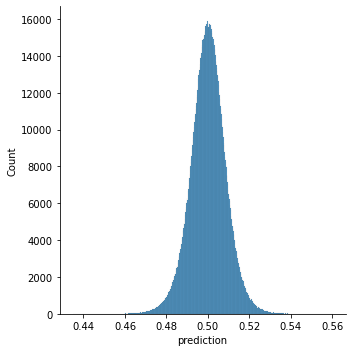

In [ ]:
import seaborn as sns

sns.displot(df['prediction'])

In [ ]:
# Save as csv file you can upload on the numerai website
df.to_csv(f'round{current_round}_pca_xgb_bayesopt_predictions.csv', index=False)

In [ ]:
# Alternatively, you can upload the csv directly to Numerai if you don't feel like locally downloading the prediction csv and manually uploading it yourself
# I like using this method because I can submit predictions directly from my phone if I am away from the computer on the weekends

# import numerapi
# napi = numerapi.NumerAPI("public_id", "secret_key")

# # upload predictions
# napi.upload_predictions("predictions.csv", model_id="model_id")

### Documentation and References

Numerapi: https://github.com/numerai/numerapi

Numerai Examples: https://github.com/numerai/example-scripts

Bayesian Optimization: https://github.com/fmfn/BayesianOptimization

XGBoost: https://github.com/dmlc/xgboost/tree/master/demo/guide-python